In [2]:
from  transformers  import XLMRobertaModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')
print('Model and Tokenizer Loaded.')

Model and Tokenizer Loaded.


In [12]:
import torch
import csv 

def load_word_senses(input_file, word,   model , tokenizer): 
    dico = {}
    with open(input_file, 'r' , encoding='utf8') as f: 
        csv_reader = csv.reader(f , delimiter='\t')
        for row in csv_reader:
            if len(row) < 2:
                print('Skipping Line:' , row)
                continue
                
            tokens = tokenizer(row[1])
            lst = tokenizer.convert_ids_to_tokens(tokens['input_ids']) 

            #Pass it to Model 
            input_ids = torch.tensor(tokens['input_ids']).unsqueeze(0)  
            if input_ids.shape[0] > 500 or input_ids.shape[1] > 500:
                print('Too long line - Skipping:')
                continue 
                
            outputs = model(input_ids)
            #Build the Vectors
            for ind , item in enumerate(lst): 
                if ind >= outputs[0].shape[1]:
                    break
                if item == '<s>' or item == '</s>':
                    continue 
                else: 
                    item = item.replace('_' , '') 
                    if item == word: 
                        print ('({}) {}'.format(row[0], row[1]))
                        if  row[0] not in dico:
                            dico[row[0]] = []  
                        dico[row[0]].append(outputs[0][0, ind , : ]) 

    return dico  

milk_items= load_word_senses('../data/common/milk.txt', 'شیر',   model , tokenizer)
    

(1)  نمونهٔ مقابل آن که فرآورد تولید مثل ببر نر با شیر ماده‌است ببشیر نامیده می‌شود 
(1) پس حتما از آمیزش ببر نر و شیر ماده هم بشیر پدید میآید 
(1)  در زمان فتحعلی‌شاه قاجار شمشیری به دست شیر داده می‌شود و استفاده از این نشان تا انقلاب ادامه پیدا می‌کند 
(1)  پرچم شیر و خورشید با شیر شمشیردار این نقش در اوایل دورهٔ قاجار به شکلی کاملاً ناهمسان روی سکه‌ها نشانها و پرچمها ظاهر شد 
(1)   یکی با نقش شمشیر علی که دو لبه‌است و دیگری با نقش یک شیر خوابیده و خورشیدی که از پشت آن طلوع می‌کند 
(1)  در یکی از این تصاویر شیر با شمشیری در دست تصویر شده‌است 
(1)  این نخستین باری است که با ظهور شیر شمشیر در دست روبه رو می‌شویم نمادی که از عصر محمدشاه قاجار به بعد به نشان متعارف ملی ایران تبدیل شد 
(1)  گویا از اواخر دوران فتحعلی شاه به تدریج دو پرچم شیر و خورشید و ذوالفقار علی با هم تلفیق می‌شود و شیر که مظهر علی بوده‌است شمشیر دریافت می‌کند 
(1) لشکر ایران در این نبرد درفشی با نشان شیر و خورشید حمل می‌نمایند و شیر در این تصویر شمشیری در دست دارد 
(1) جزئیات علامت شیر و خورشید شامل نحوهٔ رسم دم شیر م

In [ ]:
import torch

def  collect_vectors(corpus_file, words , model , tokenizer , max_found = 200): 
    dico = {}
    with open(corpus_file, 'r' , encoding='utf8') as f: 
        found = 0 
        for i, line in enumerate(f):
            
            if line.strip() == '' :
                continue
            l = line.strip().replace('.' , ' ')
            in_list = False 
            added_line = ' ' + l + ' '
            for w in words: 
                if ' ' + w + ' ' in added_line:
                    in_list = True 
                    break 
            if not in_list:
                continue 
                
            tokens = tokenizer(l)
            lst = tokenizer.convert_ids_to_tokens(tokens['input_ids']) 
            #do not pass it to model if none of the words appear in the list
            in_list = False
            for ind , item in enumerate(lst): 
                if item == '<s>' or item == '</s>':
                    continue 
                else: 
                    item = item.replace('_' , '') 
                    if item in words: 
                        in_list = True 
                        break 
            if not in_list:
                continue 
            #Pass it to Model 
            input_ids = torch.tensor(tokens['input_ids']).unsqueeze(0)  
            if input_ids.shape[0] > 500 or input_ids.shape[1] > 500:
                print('Too long line - Skipping:')
                continue 
                
            outputs = model(input_ids)
            #Build the Vectors
            for ind , item in enumerate(lst): 
                if ind >= outputs[0].shape[1]:
                    break
                if item == '<s>' or item == '</s>':
                    continue 
                else: 
                    item = item.replace('_' , '') 
                    if item in words: 
                        found += 1
                        print ('({}) {}'.format(found, l))
                        if  item not in dico:
                            dico[item] = []  
                        dico[item].append(outputs[0][0, ind , : ]) 
            if found > max_found:
                break
    return dico  


all_vectors = collect_vectors('../data/common/wiki.txt' , ['شیر'] , model, tokenizer)

#print (tokenizer('یلام لبلنل لانمیب انیلب'))


--- 1   32
--- 3   2
--- 2   28
-- 1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-- 3
3
3
-- 2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
{'1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], '3': [32, 33], '2': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}


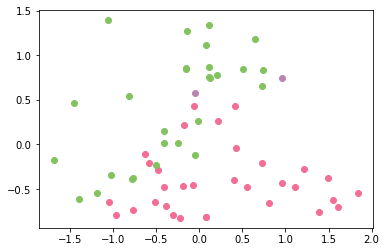

In [27]:
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt

def draw_in_2d(data_dictionary):
    pca = PCA(n_components=2)
    total_vectors = 0
    dim = 0 

    for key, value in data_dictionary.items(): 
        print('---' , key , ' ' , len(value))

        total_vectors += len(value)
        if len(value) > 0:
            dim = value[0].shape[0]

    x = np.zeros((total_vectors, dim))
    rev_index = {} 
    ind = 0 
    for key, value in data_dictionary.items(): 
        print('--' , key)
        rev_index[key] = [] 
        for vec in value:
            rev_index[key].append(ind) 
            print(key)
            x[ind , :] = vec.detach().numpy() 
            ind += 1

    x_2d = pca.fit_transform(x)
    print(rev_index)
    for key in data_dictionary: 
        plt.scatter(x_2d[ rev_index[key] , 0] , x_2d[ rev_index[key] , 1] , label=key , color=np.random.rand(3,))
    plt.show()

draw_in_2d(milk_items)